In [1]:
# Librerías:
library(randomForest)
library(mlbench)
library(caret)
library(readxl)
library(dplyr)
library(fastDummies)
library(keras)
library(pROC)
library(recipes)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘dplyr’


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Thank you for using fastDummies!

To acknowledge our work, please cite the package:

Kaplan, J. & Schlegel, B. (2023). fastDummies: Fast Creation of Dummy (Binary) Columns and Rows from Categorical Variables. Version 1.7.1. URL: https://github.com/jacobkap/fastDummies, https://jacobkap.github.io/fastDummies/.

Type 'citation("pROC")' for a citation.


Attaching package: ‘p

In [2]:
# Datos:
datosmodelo <- read_excel("/kaggle/input/datosmodelo/datosmodelo.xlsx")
datosmodelo<- datosmodelo %>% mutate(fraud_reported = as.factor(fraud_reported))

# Dividimos el conjunto en train y test:

set.seed(1234)
indice <- createDataPartition(datosmodelo$fraud_reported, p = 0.8, list=FALSE)
entrenamiento <- datosmodelo[indice,]
test <- datosmodelo[-indice,]

# Random Forest

Para el modelo del Random Forest ajustaremos los parámetros <code>mtry</code> y <code>ntree</code>.

In [3]:
customRF <- list(type = "Classification",
                 library = "randomForest",
                 loop = NULL)

customRF$parameters <- data.frame(parameter = c("mtry", "ntree"),
                                  class = rep("numeric", 2),
                                  label = c("mtry", "ntree"))

customRF$grid <- function(x, y, len = NULL, search = "grid") {}

customRF$fit <- function(x, y, wts, param, lev, last, weights, classProbs) {
  randomForest(x, y,
               mtry = param$mtry,
               ntree=param$ntree)
}

#Predict label
customRF$predict <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata)

#Predict prob
customRF$prob <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata, type = "prob")

customRF$sort <- function(x) x[order(x[,1]),]
customRF$levels <- function(x) x$classes

In [4]:
metric <- "Accuracy"

control <- trainControl(method="repeatedcv", 
                        number=10, 
                        repeats=4,
                        allowParallel = TRUE)


tunegrid <- expand.grid(.mtry=c(1:3),.ntree=seq(50,250,50))

set.seed(1234)

custom <- train(fraud_reported~., data=entrenamiento, 
                method=customRF, 
                metric=metric, 
                tuneGrid=tunegrid, 
                trControl=control)

In [5]:
custom

801 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 4 times) 
Summary of sample sizes: 721, 721, 720, 720, 721, 721, ... 
Resampling results across tuning parameters:

  mtry  ntree  Accuracy   Kappa      
  1      50    0.7528207  0.000000000
  1     100    0.7528207  0.000000000
  1     150    0.7528207  0.000000000
  1     200    0.7528207  0.000000000
  1     250    0.7528207  0.000000000
  2      50    0.7556293  0.016128035
  2     100    0.7528207  0.000000000
  2     150    0.7531293  0.001836243
  2     200    0.7528207  0.000000000
  2     250    0.7528207  0.000000000
  3      50    0.7878375  0.313779784
  3     100    0.7791225  0.278447518
  3     150    0.7815796  0.284602476
  3     200    0.7837831  0.304648647
  3     250    0.7812630  0.298993500

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 3 and ntree = 50.

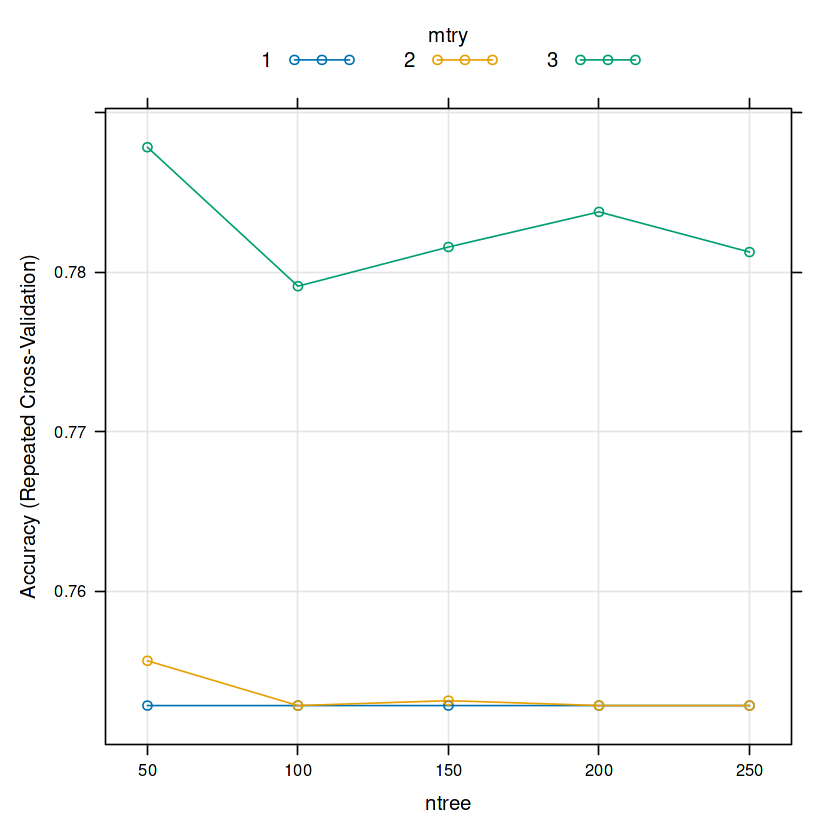

In [6]:
plot(custom)

Para la muestra de test, se tiene:

In [7]:
predicciones <- predict(custom, newdata = test)

# Calcular la matriz de confusión
matriz_confusion <- confusionMatrix(predicciones, test$fraud_reported)
print(matriz_confusion)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 137  41
         1  13   8
                                          
               Accuracy : 0.7286          
                 95% CI : (0.6612, 0.7891)
    No Information Rate : 0.7538          
    P-Value [Acc > NIR] : 0.8179676       
                                          
                  Kappa : 0.0948          
                                          
 Mcnemar's Test P-Value : 0.0002386       
                                          
            Sensitivity : 0.9133          
            Specificity : 0.1633          
         Pos Pred Value : 0.7697          
         Neg Pred Value : 0.3810          
             Prevalence : 0.7538          
         Detection Rate : 0.6884          
   Detection Prevalence : 0.8945          
      Balanced Accuracy : 0.5383          
                                          
       'Positive' Class : 0               
                              

In [42]:
predicciones <- predict(custom, newdata = test, type = "prob")
# Extrae las probabilidades de clase positiva (fraude_reported = "Yes")
predicciones_positivas <- predicciones[, "1"]

# Calcula el AUC
auc_rf <- roc(test$fraud_reported, predicciones_positivas)$auc

# Imprime el valor del AUC
print(paste("Área bajo la Curva ROC (AUC):", auc_rf))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Área bajo la Curva ROC (AUC): 0.702312925170068"


In [47]:
accuracy_rf<- matriz_confusion$overall['Accuracy']
print(paste("Exactitud:", accuracy_rf))

[1] "Exactitud: 0.728643216080402"


# Modelo SVM

In [9]:
library(e1071)

set.seed(325)
tuning <- tune(svm, fraud_reported ~ ., data = entrenamiento, 
               kernel = "linear", 
               ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 15, 20)), 
               scale = TRUE)

In [10]:
summary(tuning)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.1848457 

- Detailed performance results:
    cost     error dispersion
1  0.001 0.2472685 0.06447015
2  0.010 0.2472685 0.06447015
3  0.100 0.1848457 0.05283604
4  1.000 0.1848457 0.05283604
5  5.000 0.1848457 0.05283604
6 10.000 0.1848457 0.05283604
7 15.000 0.1848457 0.05283604
8 20.000 0.1848457 0.05283604


In [11]:
modelo_svc <- tuning$best.model
summary(modelo_svc)


Call:
best.tune(METHOD = svm, train.x = fraud_reported ~ ., data = entrenamiento, 
    ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 15, 20)), 
    kernel = "linear", scale = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 

Number of Support Vectors:  355

 ( 187 168 )


Number of Classes:  2 

Levels: 
 0 1




## Entrenamiento:

In [12]:
predicciones = predict(modelo_svc, entrenamiento)
confusionMatrix(table(prediccion = predicciones, real = entrenamiento$fraud_reported))

Confusion Matrix and Statistics

          real
prediccion   0   1
         0 515  60
         1  88 138
                                          
               Accuracy : 0.8152          
                 95% CI : (0.7866, 0.8415)
    No Information Rate : 0.7528          
    P-Value [Acc > NIR] : 1.474e-05       
                                          
                  Kappa : 0.5261          
                                          
 Mcnemar's Test P-Value : 0.02646         
                                          
            Sensitivity : 0.8541          
            Specificity : 0.6970          
         Pos Pred Value : 0.8957          
         Neg Pred Value : 0.6106          
             Prevalence : 0.7528          
         Detection Rate : 0.6429          
   Detection Prevalence : 0.7179          
      Balanced Accuracy : 0.7755          
                                          
       'Positive' Class : 0               
                                   

## Test

In [13]:
predicciones = predict(modelo_svc, test)
confusionMatrix(table(prediccion = predicciones, real = test$fraud_reported))

Confusion Matrix and Statistics

          real
prediccion   0   1
         0 129  20
         1  21  29
                                          
               Accuracy : 0.794           
                 95% CI : (0.7311, 0.8479)
    No Information Rate : 0.7538          
    P-Value [Acc > NIR] : 0.1071          
                                          
                  Kappa : 0.4488          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.8600          
            Specificity : 0.5918          
         Pos Pred Value : 0.8658          
         Neg Pred Value : 0.5800          
             Prevalence : 0.7538          
         Detection Rate : 0.6482          
   Detection Prevalence : 0.7487          
      Balanced Accuracy : 0.7259          
                                          
       'Positive' Class : 0               
                                   

Modelo con Kernel Polinomial:

In [14]:
set.seed(325)
tuning <- tune(svm, fraud_reported ~ ., data = entrenamiento, 
               kernel = "polynomial", 
               ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 15), 
                             degree = c(2, 3)), 
               scale = TRUE)

summary(tuning)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost degree
    5      2

- best performance: 0.1848457 

- Detailed performance results:
     cost degree     error dispersion
1   0.001      2 0.2472685 0.06447015
2   0.010      2 0.2472685 0.06447015
3   0.100      2 0.2472685 0.06447015
4   1.000      2 0.2073920 0.07047285
5   5.000      2 0.1848457 0.05283604
6  10.000      2 0.1848457 0.05283604
7  15.000      2 0.1848457 0.05283604
8   0.001      3 0.2472685 0.06447015
9   0.010      3 0.2472685 0.06447015
10  0.100      3 0.2472685 0.06447015
11  1.000      3 0.2335494 0.06507912
12  5.000      3 0.2085957 0.06843590
13 10.000      3 0.1961111 0.05886661
14 15.000      3 0.1973457 0.05667981


In [15]:
modelo_svmP <- svm(fraud_reported ~ ., data = entrenamiento, 
                   kernel = "polynomial", 
                   cost = 5, 
                   degree = 2, 
                   scale = TRUE, 
                   probability = TRUE)

summary(modelo_svmP)


Call:
svm(formula = fraud_reported ~ ., data = entrenamiento, kernel = "polynomial", 
    cost = 5, degree = 2, probability = TRUE, scale = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  5 
     degree:  2 
     coef.0:  0 

Number of Support Vectors:  384

 ( 210 174 )


Number of Classes:  2 

Levels: 
 0 1




In [16]:
confusionMatrix(predict(modelo_svmP, entrenamiento), entrenamiento$fraud_reported)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 515  60
         1  88 138
                                          
               Accuracy : 0.8152          
                 95% CI : (0.7866, 0.8415)
    No Information Rate : 0.7528          
    P-Value [Acc > NIR] : 1.474e-05       
                                          
                  Kappa : 0.5261          
                                          
 Mcnemar's Test P-Value : 0.02646         
                                          
            Sensitivity : 0.8541          
            Specificity : 0.6970          
         Pos Pred Value : 0.8957          
         Neg Pred Value : 0.6106          
             Prevalence : 0.7528          
         Detection Rate : 0.6429          
   Detection Prevalence : 0.7179          
      Balanced Accuracy : 0.7755          
                                          
       'Positive' Class : 0               
                              

In [100]:
matriz_svmP<- confusionMatrix(predict(modelo_svmP, test), test$fraud_reported)
matriz_svmP

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 129  20
         1  21  29
                                          
               Accuracy : 0.794           
                 95% CI : (0.7311, 0.8479)
    No Information Rate : 0.7538          
    P-Value [Acc > NIR] : 0.1071          
                                          
                  Kappa : 0.4488          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.8600          
            Specificity : 0.5918          
         Pos Pred Value : 0.8658          
         Neg Pred Value : 0.5800          
             Prevalence : 0.7538          
         Detection Rate : 0.6482          
   Detection Prevalence : 0.7487          
      Balanced Accuracy : 0.7259          
                                          
       'Positive' Class : 0               
                              

In [50]:
predicciones <- predict(modelo_svmP, newdata = test, probability = TRUE)
# Extrae las probabilidades de clase positiva (fraude_reported = "Yes")
predicciones_positivas <- attr(predicciones,"probabilities")[, 1]

# Calcula el AUC
auc_svmP <- roc(test$fraud_reported, predicciones_positivas)$auc

# Imprime el valor del AUC
print(paste("Área bajo la Curva ROC (AUC):", auc_svmP))

Setting levels: control = 0, case = 1

Setting direction: controls > cases



[1] "Área bajo la Curva ROC (AUC): 0.689115646258503"


In [101]:
accuracy_svmP<- matriz_svmP$overall['Accuracy']
print(paste("Exactitud:", accuracy_svmP))

[1] "Exactitud: 0.793969849246231"


# Modelo KNN:

In [19]:
preProcValues <- preProcess(entrenamiento, method = c("center", "scale"))
trainTransformed <- predict(preProcValues, entrenamiento)
testTransformed <- predict(preProcValues, test)

In [20]:
k_values <- seq(3,5,7)

# Genera todas las combinaciones posibles de k y metric
grid <- expand.grid(k = k_values)

# Define el esquema de validación cruzada
ctrl <- trainControl(method = "cv", number = 10)

# Ajusta los hiperparámetros usando la función train
modelo_knn <- train(fraud_reported ~ ., data = entrenamiento, method = "knn",
                    trControl = ctrl,
                    tuneGrid = grid)

# Muestra los mejores parámetros encontrados
modelo_knn

k-Nearest Neighbors 

801 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 721, 720, 721, 721, 721, 720, ... 
Resampling results:

  Accuracy   Kappa     
  0.6915639  0.06869368

Tuning parameter 'k' was held constant at a value of 3

## Mejor modelo:

In [21]:
best_modelKNN<- knn3(fraud_reported ~ ., data = trainTransformed,
                  k = modelo_knn$bestTune$k)

In [53]:
matriz_KNN<- confusionMatrix(predict(best_modelKNN, testTransformed,type = "class"), testTransformed$fraud_reported)
matriz_KNN

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 130  30
         1  20  19
                                          
               Accuracy : 0.7487          
                 95% CI : (0.6825, 0.8074)
    No Information Rate : 0.7538          
    P-Value [Acc > NIR] : 0.6025          
                                          
                  Kappa : 0.2732          
                                          
 Mcnemar's Test P-Value : 0.2031          
                                          
            Sensitivity : 0.8667          
            Specificity : 0.3878          
         Pos Pred Value : 0.8125          
         Neg Pred Value : 0.4872          
             Prevalence : 0.7538          
         Detection Rate : 0.6533          
   Detection Prevalence : 0.8040          
      Balanced Accuracy : 0.6272          
                                          
       'Positive' Class : 0               
                              

In [54]:
predicciones <- predict(best_modelKNN, newdata = testTransformed, type = "prob")
# Extrae las probabilidades de clase positiva (fraude_reported = "Yes")
predicciones_positivas <- predicciones[, "1"]

# Calcula el AUC
auc_KNN <- roc(testTransformed$fraud_reported, predicciones_positivas)$auc

# Imprime el valor del AUC
print(paste("Área bajo la Curva ROC (AUC):", auc_KNN))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Área bajo la Curva ROC (AUC): 0.625034013605442"


In [55]:
accuracy_KNN<- matriz_KNN$overall['Accuracy']
print(paste("Exactitud:", accuracy_KNN))

[1] "Exactitud: 0.748743718592965"


# XGBoost:

In [24]:
tune_grid <- expand.grid(
  nrounds = 100,
  eta = c(0.01, 0.1, 0.3),
  max_depth = c(2, 3, 5, 10),
  gamma = c(0),
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

tune_control <- caret::trainControl(
  method = "cv", # cross-validation
  number = 3, # with n folds 
  verboseIter = FALSE, # no training log
  allowParallel = TRUE #
)

xgb_tune <- caret::train(
  fraud_reported ~., data = entrenamiento,
  trControl = tune_control,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE
)

In [25]:
xgb_tune

eXtreme Gradient Boosting 

801 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 534, 534, 534 
Resampling results across tuning parameters:

  eta   max_depth  Accuracy   Kappa    
  0.01   2         0.7528090  0.0000000
  0.01   3         0.8077403  0.5017323
  0.01   5         0.8077403  0.4787230
  0.01  10         0.7852684  0.3788573
  0.10   2         0.7915106  0.4002804
  0.10   3         0.8014981  0.4265229
  0.10   5         0.7915106  0.4039849
  0.10  10         0.7727840  0.3561095
  0.30   2         0.7940075  0.3994519
  0.30   3         0.7677903  0.3345939
  0.30   5         0.7615481  0.3352634
  0.30  10         0.7615481  0.3445016

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning

Tuning parameter 'min_child_weight' was held constant at a value of 1

Tuning parameter 'subsample' was held constant at a value of 1
Accuracy was used to select the optimal model using th

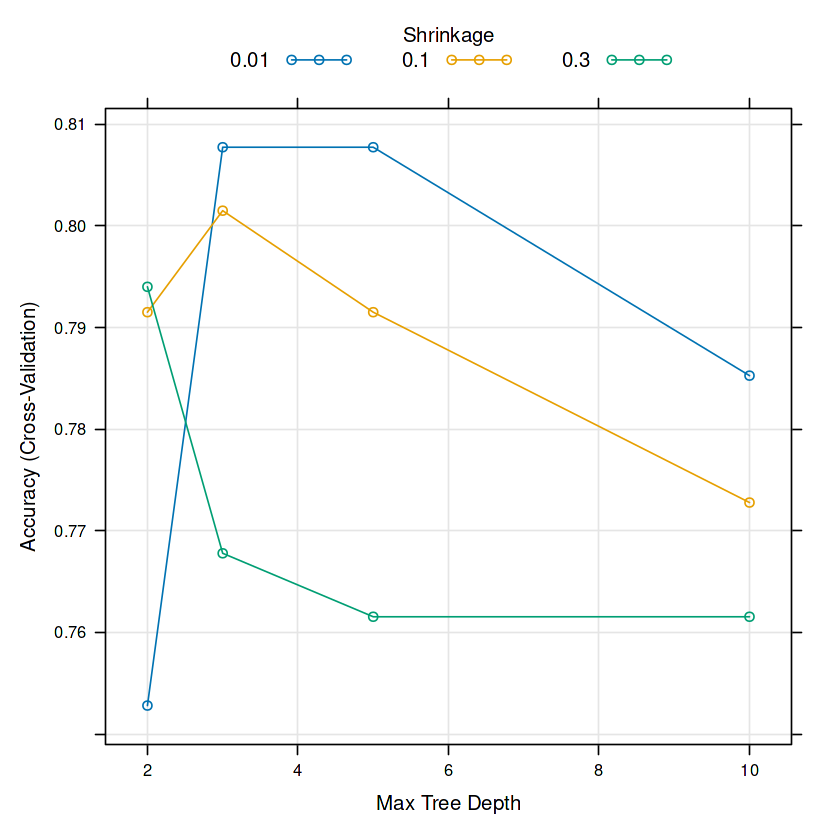

In [26]:
plot(xgb_tune)

In [27]:
confusionMatrix(predict(xgb_tune, entrenamiento), entrenamiento$fraud_reported)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 515  60
         1  88 138
                                          
               Accuracy : 0.8152          
                 95% CI : (0.7866, 0.8415)
    No Information Rate : 0.7528          
    P-Value [Acc > NIR] : 1.474e-05       
                                          
                  Kappa : 0.5261          
                                          
 Mcnemar's Test P-Value : 0.02646         
                                          
            Sensitivity : 0.8541          
            Specificity : 0.6970          
         Pos Pred Value : 0.8957          
         Neg Pred Value : 0.6106          
             Prevalence : 0.7528          
         Detection Rate : 0.6429          
   Detection Prevalence : 0.7179          
      Balanced Accuracy : 0.7755          
                                          
       'Positive' Class : 0               
                              

In [102]:
matrizXGB<- confusionMatrix(predict(xgb_tune, test), test$fraud_reported)
matrizXGB

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 129  20
         1  21  29
                                          
               Accuracy : 0.794           
                 95% CI : (0.7311, 0.8479)
    No Information Rate : 0.7538          
    P-Value [Acc > NIR] : 0.1071          
                                          
                  Kappa : 0.4488          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.8600          
            Specificity : 0.5918          
         Pos Pred Value : 0.8658          
         Neg Pred Value : 0.5800          
             Prevalence : 0.7538          
         Detection Rate : 0.6482          
   Detection Prevalence : 0.7487          
      Balanced Accuracy : 0.7259          
                                          
       'Positive' Class : 0               
                              

In [103]:
predicciones <- predict(xgb_tune, newdata = test, type = "prob")
# Extrae las probabilidades de clase positiva (fraude_reported = "Yes")
predicciones_positivas <- predicciones[, "1"]

# Calcula el AUC
auc_XGB <- roc(test$fraud_reported, predicciones_positivas)$auc

# Imprime el valor del AUC
print(paste("Área bajo la Curva ROC (AUC):", auc_XGB))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Área bajo la Curva ROC (AUC): 0.696530612244898"


In [104]:
accuracy_XGB<- matrizXGB$overall['Accuracy']
print(paste("Exactitud:", accuracy_XGB))

[1] "Exactitud: 0.793969849246231"


# Red Neuronal

In [30]:
X_train<- entrenamiento %>% select(-fraud_reported)
y_train<- entrenamiento$fraud_reported
y_train<- ifelse(y_train == "1", 1,0)
# Test:
X_test<- test %>% select(-fraud_reported)
y_test<- test$fraud_reported
y_test<- ifelse(y_test == "1", 1,0)

receta <- recipe(fraud_reported ~ ., data = entrenamiento) %>%
  step_normalize(all_numeric_predictors()) %>%
  step_dummy(all_nominal_predictors())   

receta_prep <- prep(receta, training = entrenamiento)

X_train <- as.matrix(bake(receta_prep, new_data = X_train))
X_test <- as.matrix(bake(receta_prep, new_data = X_test))

In [31]:
modelo <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = ncol(X_train)) %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 1, activation = "sigmoid")

In [32]:
modelo %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_adam(),
  metrics = "accuracy"
)

In [33]:
print_callback <- callback_lambda(
  on_epoch_end = function(epoch, logs) {
    cat(sprintf("Época %d - Precisión: %.4f - Pérdida: %.4f\n", epoch, logs$val_accuracy, logs$val_loss))
  }
)

# Entrena el modelo con el callback personalizado
history <- modelo %>% fit(
  X_train, y_train,
  epochs = 15,
  batch_size = 32,
  #validation_split = 0.2,
  validation_data = list(X_test, y_test),
  callbacks = list(print_callback)
)

Época 0 - Precisión: 0.7588 - Pérdida: 0.5937
Época 1 - Precisión: 0.7538 - Pérdida: 0.5568
Época 2 - Precisión: 0.7538 - Pérdida: 0.5496
Época 3 - Precisión: 0.7538 - Pérdida: 0.5444
Época 4 - Precisión: 0.7538 - Pérdida: 0.5413
Época 5 - Precisión: 0.7538 - Pérdida: 0.5367
Época 6 - Precisión: 0.7538 - Pérdida: 0.5319
Época 7 - Precisión: 0.7538 - Pérdida: 0.5266
Época 8 - Precisión: 0.7538 - Pérdida: 0.5227
Época 9 - Precisión: 0.7538 - Pérdida: 0.5194
Época 10 - Precisión: 0.7487 - Pérdida: 0.5161
Época 11 - Precisión: 0.7437 - Pérdida: 0.5111
Época 12 - Precisión: 0.7487 - Pérdida: 0.5091
Época 13 - Precisión: 0.7739 - Pérdida: 0.5068
Época 14 - Precisión: 0.7688 - Pérdida: 0.5061


In [71]:
resultado <- modelo %>% evaluate(as.matrix(X_test), y_test)

In [72]:
resultado

loss  accuracy 
0.5060940 0.7688442

In [73]:
predicciones_prob <- modelo %>% predict(X_test)

In [91]:
predicciones_clases <- as.factor(ifelse(predicciones_prob > 0.5, 1, 0))
matriz_RNN<- confusionMatrix(predicciones_clases, test$fraud_reported)

In [65]:
auc_RNmatriz_RNNN <- roc(test$fraud_reported,  as.vector(predicciones_prob) )$auc
print(paste("Área bajo la Curva ROC (AUC):", auc_RNN))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Área bajo la Curva ROC (AUC): 0.708027210884354"


In [93]:
accuracy_RNN<- matriz_RNN$overall['Accuracy']
print(paste("Exactitud:", accuracy_RNN))

[1] "Exactitud: 0.768844221105528"


Presentamos la exactitud y el valor de AUC para cada modelo:

In [105]:
resumen<- data.frame(
    Modelo = c("RF", "SVM", "KNN", "XGB", "RNN"),
    Exactitud = c(accuracy_rf, accuracy_svmP, accuracy_KNN, accuracy_XGB, accuracy_RNN), 
    AUC = c(auc_rf, auc_svmP, auc_KNN, auc_XGB, auc_RNN)
                    )
resumen

Modelo,Exactitud,AUC
<chr>,<dbl>,<dbl>
RF,0.7286432,0.7023129
SVM,0.7939698,0.6891156
KNN,0.7487437,0.6250340
XGB,0.7939698,0.6965306
RNN,0.7688442,0.7080272


Así, podemos ver que el modelo con la mejor precisión es el XGBoost, seguido del SVM. No obstantre, el modelo XGBoost posee un mayor valor para el AUC.

## Interpretación del modelo:

Vamos a utilizar shap - values para interpretar los modelos de Random Forest y XGBoost.

In [38]:
library(iml)
best_model <- xgb_tune$finalModel

In [39]:
X <- entrenamiento[which(names(entrenamiento) != "fraud_reported")]

predictor <- Predictor$new(custom, data = X, y = entrenamiento$fraud_reported)

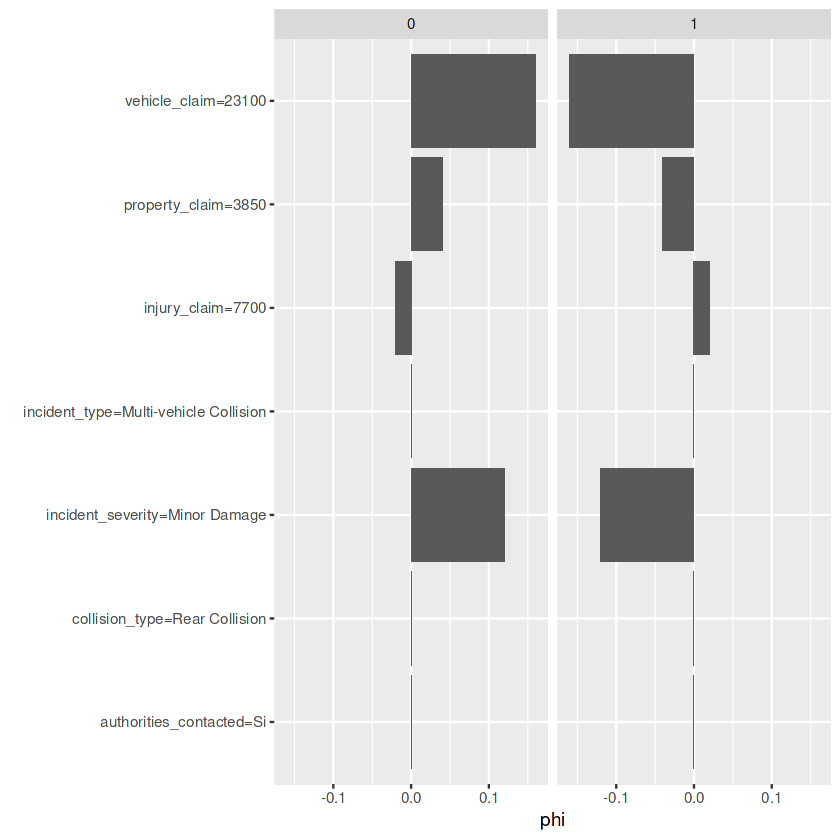

In [40]:
shapley <- Shapley$new(predictor, x.interest = X[1, ], sample.size = 50)
shapley$plot()

Así, de la gráfica podemos ver que cuando variable $vehicle_claim$ toma el valor de $23100$, está asociado con un valor alto de $\phi$, Así, se tiene una mayor probabilidad de no ocurrencia de fraude. Análogamente, para $incident\_severity$,se tirnr que la presencia de un incidente de con daños menores (Minor Damage) está asociada con una mayor probabilidad de no incurrir en fraude. 

Lo contrario sucede con la variable $injury\_claim$, cuando esta toma el valor de $7700 $ aumenta la probabilidad de fraude.